In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = True

## pre-processing step

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat" # give the directory of images
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}  
    training_data = []
    catcount = 0
    dogcount = 0 # make sure the "balance"
    
    def make_training_data(self):
        for label in self.LABELS: #iterate the directory
            print(label)
            for f in tqdm(os.listdir(label)):  # iterate all the image within the directory, f -> the file name
                try:
                    path = os.path.join(label, f) # get the full path to the image
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert the iimage to gray scale (optional)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

PetImages/Cat


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:38<00:00, 326.75it/s]


PetImages/Dog


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:39<00:00, 312.71it/s]


Cats: 12476
Dogs: 12470


In [2]:
training_data = np.load("training_data.npy", allow_pickle = True)

In [3]:
print(len(training_data))

24946


In [4]:
for i in range(4):
    print(training_data[i])

[array([[111, 111, 253, ...,  56,  47,  57],
       [110, 116, 214, ...,  60,  59,  54],
       [122, 122, 128, ...,  60,  53,  57],
       ...,
       [ 79,  87,  84, ...,  94,  76,  72],
       [ 82,  78,  89, ...,  90,  62,  73],
       [ 70,  78,  85, ...,  89,  79,  65]], dtype=uint8)
 array([1., 0.])]
[array([[221, 222, 224, ..., 225, 224, 220],
       [216, 219, 222, ..., 221, 218, 215],
       [213, 217, 218, ..., 217, 215, 212],
       ...,
       [143, 155, 166, ..., 131, 112,  90],
       [161, 166, 165, ...,  25,  30,  45],
       [171, 171, 150, ...,  33,  39,  49]], dtype=uint8)
 array([1., 0.])]
[array([[115, 118, 119, ..., 108, 108, 108],
       [114,  70, 115, ..., 108, 108, 108],
       [114,   5,  10, ..., 107, 108, 110],
       ...,
       [115, 118, 118, ..., 112, 111, 109],
       [127, 129, 134, ..., 113, 114, 111],
       [ 83,  46,  63, ..., 115, 112, 112]], dtype=uint8)
 array([1., 0.])]
[array([[239, 239, 239, ..., 237, 241, 243],
       [235, 237, 237, ..., 

In [5]:
import matplotlib.pyplot as plt


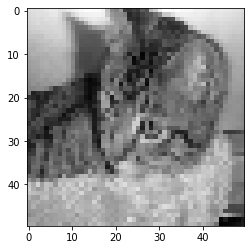

In [6]:
plt.imshow(training_data[1][0], cmap="gray")
plt.show()

In [7]:
print(training_data[1])

[array([[221, 222, 224, ..., 225, 224, 220],
       [216, 219, 222, ..., 221, 218, 215],
       [213, 217, 218, ..., 217, 215, 212],
       ...,
       [143, 155, 166, ..., 131, 112,  90],
       [161, 166, 165, ...,  25,  30,  45],
       [171, 171, 150, ...,  33,  39,  49]], dtype=uint8)
 array([1., 0.])]


In [8]:
for i in range(5):
    print(training_data[i][1])

[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]


In [9]:
training_data[1][0]

array([[221, 222, 224, ..., 225, 224, 220],
       [216, 219, 222, ..., 221, 218, 215],
       [213, 217, 218, ..., 217, 215, 212],
       ...,
       [143, 155, 166, ..., 131, 112,  90],
       [161, 166, 165, ...,  25,  30,  45],
       [171, 171, 150, ...,  33,  39,  49]], dtype=uint8)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Making layers
        self.conv1 = nn.Conv2d(1, 32, 5) # 1st layer
        # 5 -> kernel size, which means that it will form a 5 by 5 window 
        # to roll over the data to find features
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        # Eventually output to at least one linear layer
        # self.fc1 = nn.Linear(???, 512)
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)        
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        #print(x[0].shape)
        
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # flatten
        x = F.relu(self.fc1(x)) # put into the first fully connected layer
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()    

In [12]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0  # scaling the imagery which means that turn the pixel values form (0~255) to (0~1)
y = torch.Tensor([i[1] for i in training_data])

# Separate the training ant testing data
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)


2494


In [13]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [16]:
BATCH_SIZE = 100
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # tqdm -> show the progress bar
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)
        

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [01:31<00:00,  2.45it/s]


tensor(0.1397, grad_fn=<MseLossBackward>)


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
            
        total += 1
        
print("Accuracy:", round(correct/total,3))

100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:09<00:00, 253.09it/s]


Accuracy: 0.733
